## Imports

In [6]:
from matplotlib import gridspec
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

if False:
    import seaborn as sns
    sns.set_theme()
    sns.set_style("whitegrid")


import warnings
def relplot(*args, **kwargs):
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        return sns.relplot(*args, **kwargs)


simulations_path = Path(
    '/home/selker/eop/eop/run_togo_simulations/simulations'
)
figs_path = Path(simulations_path / 'figs')
figs_path.mkdir(exist_ok=True)



# Policy performance

## Comparing targeting approaches

In [80]:
predictors_list = [
    'satellite', 'survey_satellite_sample'
]
predictor_based_policy_types = [
    'continuous_gap', 
]

In [81]:
performance_across_predictors_and_approaches = []

for policy_type in ['oracle_gap', 'ubi']:
    performance = pd.read_csv(
        simulations_path / 'learn' / 'results' / 
        'togo_satellite' / 'year=2017' / f'{policy_type}.csv'
    )
    performance['predictors'] = 'None'
    performance_across_predictors_and_approaches.append(performance)

for predictors in predictors_list:
    
    for policy_type in predictor_based_policy_types:
        transfer_method_prefix = f'output_gt_{policy_type}'
        performance = pd.read_csv(
            simulations_path / 'learn' / 'results' / 
            f'togo_{predictors}' / 'year=2017' / f'{transfer_method_prefix}.csv'
        )
        performance['predictors'] = predictors
        performance_across_predictors_and_approaches.append(performance)

    
performance_across_predictors_and_approaches = pd.concat(performance_across_predictors_and_approaches)


<Figure size 2000x1200 with 0 Axes>

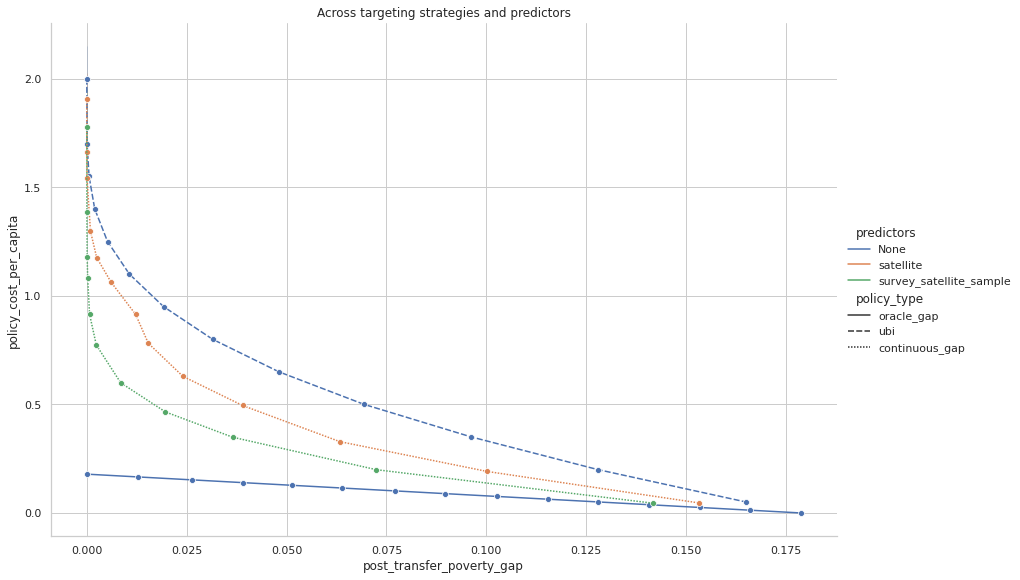

In [82]:
plt.figure(figsize=(10, 6), dpi=200) # Creates a figure 10 inches wide and 6 inches tall
to_plot = performance_across_predictors_and_approaches[
    ~performance_across_predictors_and_approaches.policy_type.isin(['binary_gap', 'pmt'])
]

fg = relplot(
    data=to_plot, x='post_transfer_poverty_gap', y='policy_cost_per_capita', 
    hue='predictors', style='policy_type', kind='line', 
    marker='o', height=8, aspect=12/8,
)
fg.set( title=f'Across targeting strategies and predictors')
# fg.savefig(figs_path / f'satellite_vs_oracle_vs_ubi.png')

# Make plots using Roshni's tools

In [14]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/selker/eop/poverty/dry_run'))
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import learn.aggregation

import importlib
importlib.reload(learn.aggregation)
(
    METHODS,
    AggregatePovertyResults,
    CountryMethodPovertyResults,
    preprocess_country_aux_data,
    SECONDARY_AUX_DATA_CSV,
    preprocess_wpc_data,
) = (
    learn.aggregation.METHODS,
    learn.aggregation.AggregatePovertyResults,
    learn.aggregation.CountryMethodPovertyResults,
    learn.aggregation.preprocess_country_aux_data,
    learn.aggregation.SECONDARY_AUX_DATA_CSV,
    learn.aggregation.preprocess_wpc_data
)

def make_plot_for_country(
    country,
    method_list,
    geo_extrapolation,
    setting_codes,
    povertyline,
    year,
    save_as,
    ubi_on=True,
):

    results = dict()

    for method in method_list:
        results[method] = dict()
        for setting_code in setting_codes:
            results[method][setting_code] = (
                CountryMethodPovertyResults(
                    country, method, geo_extrapolation, setting_code, povertyline=povertyline, year=year
                )
            )
    # Get costs
    rate_target = 1.0
    gap_target = results['continuous_gap']['togo_survey_satellite_sample'].rate_to_gap_interpolator(rate_target)

    cost_table = []
    for method in results.keys():
        for setting_code in results[method].keys():
            setting_costs = dict()
            setting_costs['method'] = method
            setting_costs['setting_code'] = setting_code
            setting_costs['rate_cost'] = results[method][setting_code].rate_to_cost_interpolator(rate_target)
            setting_costs['gap_cost'] = results[method][setting_code].gap_to_cost_interpolator(gap_target)
            setting_costs['gap_target'] = gap_target
            cost_table.append(setting_costs)

    cost_table = pd.DataFrame(cost_table)

    oracle_results = CountryMethodPovertyResults(
        country, "oracle_gap", geo_extrapolation, 'togo_satellite', povertyline=povertyline, year=year
    )
    fontsize = 30
    # Plot policy_cost_per_capita vs post_transfer_poverty_rate
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    if ubi_on:
        cost = povertyline * results[method][setting_code].conversion_factor
        print('ubi_cost', cost)
        ax[0].vlines(
            x=rate_target,
            ymin=0,
            ymax=cost,
            color="grey",
            linestyle="solid",
            linewidth=3,
        )
        ax[1].vlines(
            x=gap_target,
            ymin=0,
            ymax=cost,
            color="grey",
            linestyle="solid",
            linewidth=3,
        )
        ax[0].scatter(
            [rate_target],
            [cost],
            color=METHODS["ubi"]["color"],
            s=100,
            zorder=3,
        )
        ax[1].scatter(
            [gap_target],
            [cost],
            color=METHODS["ubi"]["color"],
            s=100,
            zorder=3,
        )
    
        ax[1].plot(
            np.linspace(0.0, results[method][setting_code].initial_gap_index),
            np.ones(50) * cost,
            linestyle="--",
            color=METHODS["ubi"]["color"],
            label="UBI ${}".format(povertyline),
            linewidth=3,
        )
        ax[0].plot(
            np.linspace(0.0, results[method][setting_code].initial_rate),
            np.ones(50) * cost,
            linestyle="--",
            color=METHODS["ubi"]["color"],
            label="UBI ${}".format(povertyline),
            linewidth=3,
        )
    setting_color_map = {
        'togo_cdr': 'purple',
        'togo_cdr_and_survey': 'violet',
        'togo_satellite': 'turquoise',
        'togo_satellite_and_survey': 'yellow',
        'togo_survey_satellite_sample': 'blue',
    }
    special_setting_style_map = {
        'unused': '--'
    }
    method_style_map = {
        'continuous_gap': '-',
        'binary_gap': '--',
        'modern_pmt': ':',
        'ubi': '-',
        'oracle_gap': '-'
    }
    special_method_color_map = {
        'oracle_gap': METHODS["oracle_gap"]["color"],
        'ubi': METHODS["ubi"]["color"]
    }

    def get_label(method, setting_code):
        if method == 'ubi':
            return 'UBI by Country'
        elif method == 'oracle_gap':
            return 'Oracle Gap Minimization'
        if method == 'continuous_gap':
            method_label = 'Gap Minimization'
        elif method == 'binary_gap':
            method_label = 'Binary Gap Minimization'
        else:
            raise ValueError('Unknown method {}'.format(method))
        setting_name_map = {
            'togo_cdr': 'CDR',
            'togo_cdr_and_survey': 'CDR + Survey',
            'togo_satellite': 'Satellite Imagery',
            'togo_satellite_and_survey': 'Satellite Imagery + Survey Predictors',
            'togo_survey_satellite_sample': 'Survey Predictors',
        }
        assert setting_code in setting_name_map.keys(), 'Unknown setting code {}'.format(setting_code)
        return f'{method_label} ({setting_name_map[setting_code]})'

    rate_target = rate_target

    vertical_arrow_rate = True
    vertical_arrow_gap = True


    gap_target = results['continuous_gap']['togo_survey_satellite_sample'].rate_to_gap_interpolator(rate_target)
    for i, setting_code in enumerate(setting_codes):
        for method in method_list:
            if method in ('ubi', 'oracle_gap') and i > 0:
                continue
            if method in special_method_color_map.keys():
                color=special_method_color_map[method]
            else:
                color = setting_color_map[setting_code]

            if setting_code in special_setting_style_map.keys() and method == 'continuous_gap':
                style = special_setting_style_map[setting_code]
            else:
                style = method_style_map[method]

            label = get_label(method, setting_code)
            results_instance = results[method][setting_code]

            point = results_instance.rate_to_cost_interpolator(rate_target)
            gap_cost = results_instance.gap_to_cost_interpolator(gap_target).item()

            if vertical_arrow_rate:
                ax[0].vlines(
                    x=rate_target,
                    ymin=0,
                    ymax=point,
                    color="grey",
                    linestyle="solid",
                    linewidth=3,
                )
                if method != "oracle_gap":
                    ax[0].scatter(
                        [rate_target],
                        [point],
                        color=color,
                        s=100,
                        zorder=3,
                    )

            if vertical_arrow_gap:

                ax[1].vlines(
                    x=gap_target,
                    ymin=0,
                    ymax=gap_cost,
                    color="grey",
                    linestyle="solid",
                    linewidth=3,
                )

                ax[1].scatter(
                    [gap_target],
                    [gap_cost],
                    color=color,
                    s=100,
                    zorder=3,
                )
            
            # dic = methods[method]
            df = results_instance._load_data(method)

            rates = [oracle_results.initial_rate] + list(
                df["post_transfer_poverty_rate"] * 100
            )
            gaps = [oracle_results.initial_gap_index] + list(
                df["post_transfer_poverty_gap"] * 100 / povertyline
            )
            costs = [0.0] + list(
                df["policy_cost_per_capita"] * results_instance.conversion_factor
            )


            if method != 'oracle_gap':
                ax[0].plot(
                    rates,
                    costs,
                    label=label,
                    color=color,
                    linestyle=style,
                    linewidth=3,
                )

            ax[1].plot(
                gaps,
                costs,
                label=label,
                color=color,
                linestyle=style,
                linewidth=3,
            )
    ax[0].set_xlabel(
        "Post-Transfer Poverty Rate \n(%)",
        fontsize=fontsize,
    )
    ax[1].set_xlabel(
        "Post-Transfer Poverty Gap Index \n(%)",
        fontsize=fontsize,
    )

    for i in range(2):
        ax[i].set_ylabel("Policy Cost ($ Billion Per Year)", fontsize=fontsize)
        ax[i].grid(True)
        ax[i].tick_params(axis="x", labelsize=fontsize * 0.75)
        ax[i].tick_params(axis="y", labelsize=fontsize * 0.75)
    
    ax[1].legend(fontsize=fontsize * 0.75) # , bbox_to_anchor=(0.4, 0.9))
    # fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.tight_layout()
    plt.savefig("{}.pdf".format(save_as), bbox_inches="tight")
    plt.show()
    plt.close()
    return cost_table


ubi_cost 3.3151003146104427


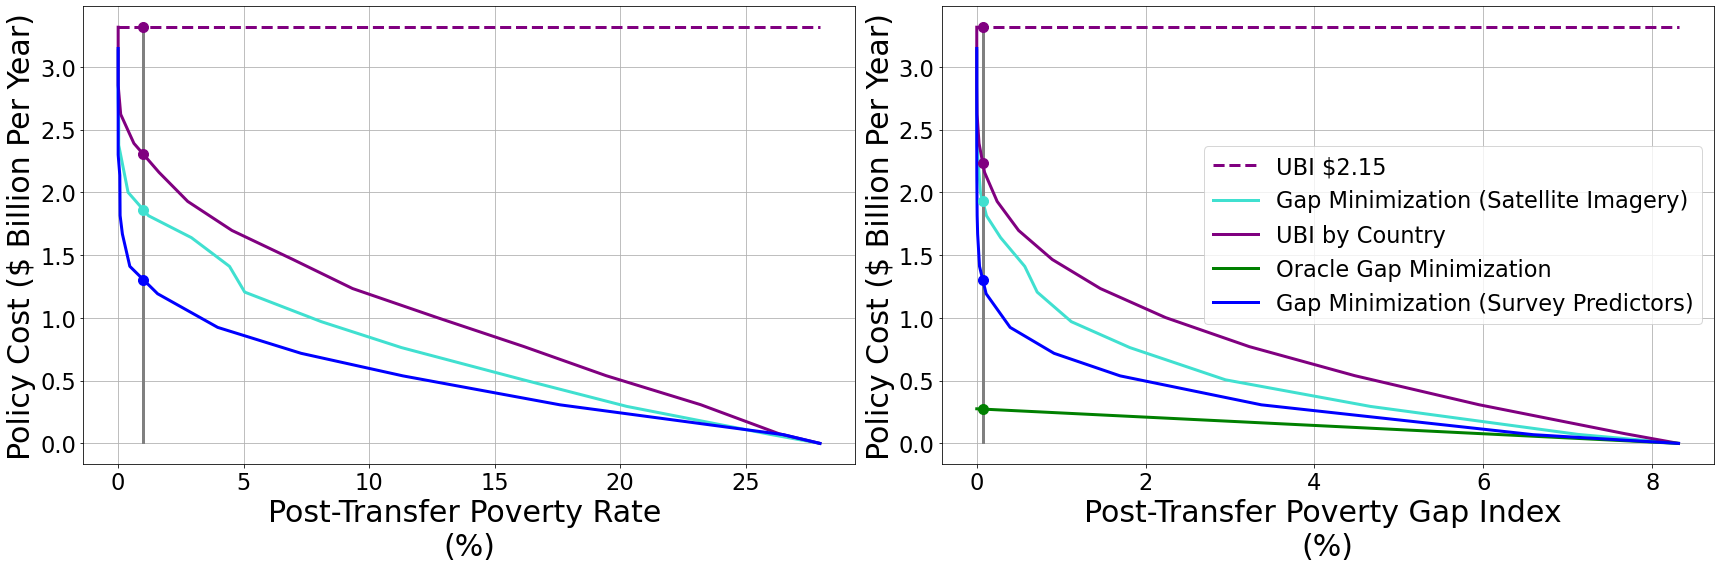

In [15]:
cost_table = make_plot_for_country(
    country='togo',
    method_list=['continuous_gap', 'ubi', 'oracle_gap', ],
    geo_extrapolation=True,
    setting_codes=[
        'togo_satellite', 
        'togo_survey_satellite_sample'
    ],
    povertyline=2.15,
    year=2017,
    save_as=figs_path / 'satellite_vs_survey',
    ubi_on=True
)

In [45]:
cost_table

,method,setting_code,rate_cost,gap_cost,gap_target
0,continuous_gap,togo_satellite,1.8615968992767131,1.9292866687867807,0.07052065485984674
1,continuous_gap,togo_survey_satellite_sample,1.3048098189401558,1.3048098189401558,0.07052065485984674
2,ubi,togo_satellite,2.303864247695836,2.2357394491638303,0.07052065485984674
3,ubi,togo_survey_satellite_sample,2.303864247695836,2.2357394491638303,0.07052065485984674
4,oracle_gap,togo_satellite,0.26568676641849,0.2732037256752071,0.07052065485984674
5,oracle_gap,togo_survey_satellite_sample,0.26568676641849,0.2732037256752071,0.07052065485984674


In [59]:
ratios = dict()
ratios['satellite_over_survey'] = cost_table[
    (cost_table.method == 'continuous_gap')
    & (cost_table.setting_code == 'togo_satellite')
].rate_cost.astype('float').item() / cost_table[
    (cost_table.method == 'continuous_gap')
    & (cost_table.setting_code == 'togo_survey_satellite_sample')
].rate_cost.astype('float').item()
ratios['satellite_over_oracle'] = cost_table[
    (cost_table.method == 'continuous_gap')
    & (cost_table.setting_code == 'togo_satellite')
].rate_cost.astype('float').item()/ cost_table[
    (cost_table.method == 'oracle_gap')
    & (cost_table.setting_code == 'togo_survey_satellite_sample')
].rate_cost.astype('float').item()

ratios['ubi_over_satellite'] = cost_table[
    (cost_table.method == 'ubi')
    & (cost_table.setting_code == 'togo_satellite')
].rate_cost.astype('float').item() / cost_table[
    (cost_table.method == 'continuous_gap')
    & (cost_table.setting_code == 'togo_satellite')
].rate_cost.astype('float').item()

In [61]:
ratios

{'satellite_over_survey': 1.4267189534094806,
 'satellite_over_oracle': 7.006735504260925,
 'ubi_over_satellite': 1.2375741754785676}

In [57]:
cost_table.loc[
    (cost_table.method == 'ubi') & (cost_table.setting_code == 'togo_satellite'), 'rate_cost'].astype('float').item()


2.303864247695836

# Hyperparam search

In [ ]:
hyperparameter_output_directory = simulations_path / 'hparam' / 'results'
hyperparameters = dict()

## Binary gap

In [ ]:
binary_gap_nn_results = pd.read_csv(hyperparameter_output_directory / 'nn_gt_binary_gap.csv')
averages = (
    binary_gap_nn_results
    .groupby(['n_layers', 'n_hidden_units', 'lr']).mean().reset_index()
)
binary_gap_hyperparameters = (
    averages.loc[averages["loss"].idxmin()].to_dict()
)

binary_gap_n_regressors_results = pd.read_csv(
    hyperparameter_output_directory / 'n_regressors_gt_binary_gap.csv'
)
averages = (
    binary_gap_n_regressors_results
    .groupby(['n_regressors']).mean().reset_index()
)
binary_gap_hyperparameters.update(
    averages.loc[averages["auc"].idxmin()].to_dict()
)

del binary_gap_hyperparameters['loss']
del binary_gap_hyperparameters["transfer_size"]
del binary_gap_hyperparameters["trial"]
del binary_gap_hyperparameters['auc']

hyperparameters['binary_gap'] = {'gt': binary_gap_hyperparameters}

## Continuous gap

In [ ]:
continuous_gap_nn_results = pd.read_csv(hyperparameter_output_directory / 'nn_gt_continuous_gap.csv')
averages = (
    continuous_gap_nn_results
    .groupby(['n_layers', 'n_hidden_units', 'lr']).mean().reset_index()
)
continuous_gap_hyperparameters = (
    averages.loc[averages["pinball_loss"].idxmin()].to_dict()
)

continuous_gap_n_regressors_results = pd.read_csv(
    hyperparameter_output_directory / 'n_regressors_gt_continuous_gap.csv'
)
averages = (
    continuous_gap_n_regressors_results
    .groupby(['n_regressors']).mean().reset_index()
)
continuous_gap_hyperparameters.update(
    averages.loc[averages["auc"].idxmin()].to_dict()
)

del continuous_gap_hyperparameters['pinball_loss']
del continuous_gap_hyperparameters["quantile"]
del continuous_gap_hyperparameters["trial"]
del continuous_gap_hyperparameters['auc']

hyperparameters['continuous_gap'] = {'gt': continuous_gap_hyperparameters}

FileNotFoundError: [Errno 2] No such file or directory: '/home/selker/eop/eop/run_togo_simulations/simulations_stashed/hparam/results/nn_gt_continuous_gap.csv'

## Binary rate

In [ ]:

binary_rate_nn_results = pd.read_csv(hyperparameter_output_directory / 'nn_gt_binary_rate.csv')
averages = (
    binary_rate_nn_results
    .groupby(['n_layers', 'n_hidden_units', 'lr']).mean().reset_index()
)
binary_rate_hyperparameters = (
    averages.loc[averages["loss"].idxmin()].to_dict()
)

binary_rate_n_regressors_results = pd.read_csv(
    hyperparameter_output_directory / 'n_regressors_gt_binary_rate.csv'
)
averages = (
    binary_rate_n_regressors_results
    .groupby(['n_regressors']).mean().reset_index()
)
binary_rate_hyperparameters.update(
    averages.loc[averages["auc"].idxmin()].to_dict()
)

del binary_rate_hyperparameters['loss']
del binary_rate_hyperparameters["transfer_size"]
del binary_rate_hyperparameters["trial"]
del binary_rate_hyperparameters['auc']


hyperparameters['binary_rate'] = {'gt': binary_rate_hyperparameters}

## Continuous rate

In [ ]:
continuous_rate_n_alpha_results = pd.read_csv(
    hyperparameter_output_directory / 'n_alpha_gt_continuous_rate.csv'
)
averages = continuous_rate_n_alpha_results.groupby('n_alpha').mean().reset_index()
continuous_rate_hyperparameters = (
    averages.loc[averages["auc"].idxmin()].to_dict()
)

continuous_rate_density_estimation_results = pd.read_csv(
    hyperparameter_output_directory / 'density_estimation_gt_continuous_rate.csv'
)
averages = continuous_rate_density_estimation_results.groupby(
    ['degree', 'n_bins', 'n_knots', 'n_features']
).mean().reset_index()

continuous_rate_hyperparameters.update(
    averages.loc[averages["nll"].idxmin()].to_dict()
)
del continuous_rate_hyperparameters['auc']
del continuous_rate_hyperparameters['nll']
del continuous_rate_hyperparameters['trial']

hyperparameters['continuous_rate'] = {'gt': continuous_rate_hyperparameters}

## Default hyperparameters

In [ ]:
from yaml import SafeLoader
with (simulations_path / 'hparam/configs/default_config.yml').open('r') as default_config_file:
    default_config = SafeLoader(default_config_file).get_data()

hyperparameter_name_map = {
    'num_hidden_layers': 'n_layers', 'num_hidden_units': 'n_hidden_units'
}

continuous_rate_default_hyperparameters = default_config['continuous_rate']
for key, value in continuous_rate_default_hyperparameters['density_estimation'].items():
    continuous_rate_default_hyperparameters[key] = value
del continuous_rate_default_hyperparameters['density_estimation']
hyperparameters['continuous_rate']['default'] = continuous_rate_default_hyperparameters

for model_type in ('continuous_gap', 'binary_gap', 'binary_rate'):
    default_hyperparameters = default_config[model_type]
    for key, value in default_hyperparameters['neural_network'].items():
        default_hyperparameters[hyperparameter_name_map.get(key, key)] = value
    del default_hyperparameters['neural_network']
    hyperparameters[model_type]['default'] = default_hyperparameters

for model_type, dict in hyperparameters.items():
    hyperparameters[model_type] = pd.DataFrame.from_dict(dict)

## Print results

In [ ]:
for key, value in hyperparameters.items():
    display(key)
    display(value)